In [1]:
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData

from cil.processors import Slicer, AbsorptionTransmissionConverter, TransmissionAbsorptionConverter

from cil.optimisation.functions import IndicatorBox
from cil.optimisation.algorithms import CGLS, SIRT

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP

from cil.plugins import TomoPhantom

from cil.utilities import dataexample
from cil.utilities.display import show2D, show1D, show_geometry

# External imports
import numpy as np
import matplotlib.pyplot as plt
import logging

# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'

/home/bih17925/miniconda3/envs/cil_testing2/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# number of pixels
n_pixels = 256

# Angles
angles = np.linspace(0, 180, 256, endpoint=False, dtype=np.float32)


# Setup acquisition geometry
# with sufficient number of projections
ag = AcquisitionGeometry.create_Parallel2D()\
                            .set_angles(angles)\
                            .set_panel(n_pixels, pixel_size=1/n_pixels)

# Setup image geometry
ig = ImageGeometry(voxel_num_x=n_pixels, 
                   voxel_num_y=n_pixels, 
                   voxel_size_x=1/n_pixels, 
                   voxel_size_y=1/n_pixels)

# Get phantom
phantom = TomoPhantom.get_ImageData(num_model=1, geometry=ig)

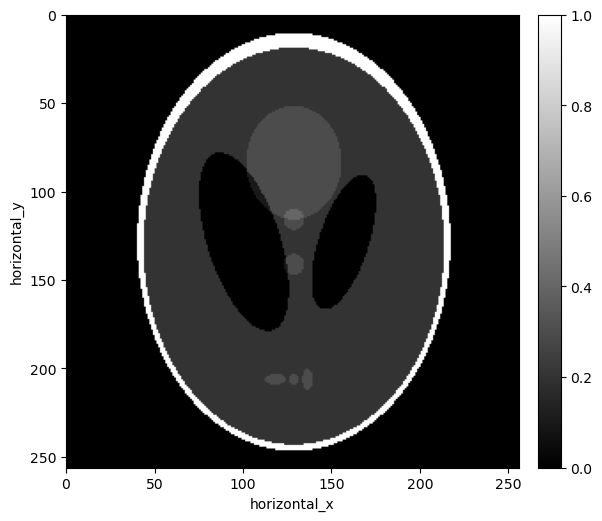

In [3]:
# Visualise data
show2D(phantom, cmap=cmap, num_cols=1, size=(10,10), origin='upper-left')

In [4]:
# Create projection operator using Astra-Toolbox.
A = ProjectionOperator(ig, ag, device)

# Create an acquisition data (numerically)
sino = A.direct(phantom)


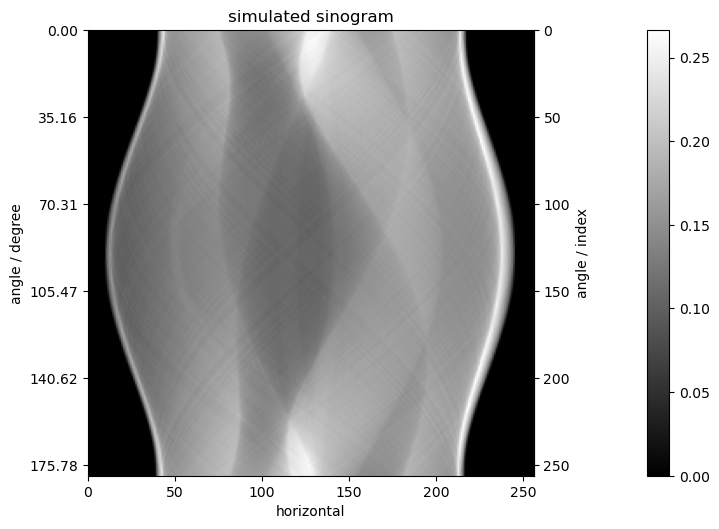

In [5]:
# Visualise data
show2D(sino, 'simulated sinogram', cmap=cmap, size=(10,10), origin='upper-left')

In [6]:
# reconstruct full data
# configure FBP
fbp = FBP(ig, ag, device)
# run on the AcquisitionData
recon_fbp = fbp(sino)

In [7]:
# Incident intensity: lower counts will increase the noise
background_counts = 20000 

# Convert the simulated absorption sinogram to transmission values using Lambert-Beer. 
# Use as mean for Poisson data generation.
# Convert back to absorption sinogram.
counts = background_counts * np.exp(-sino.as_array())
tmp = np.exp(-sino.as_array())
noisy_counts = np.random.poisson(counts)
nonzero = noisy_counts > 0
sino_out = np.zeros_like(sino.as_array())
sino_out[nonzero] = -np.log(noisy_counts[nonzero] / background_counts)

# allocate sino_noisy and fill with noisy data
sino_noisy = ag.allocate()
sino_noisy.fill(sino_out)

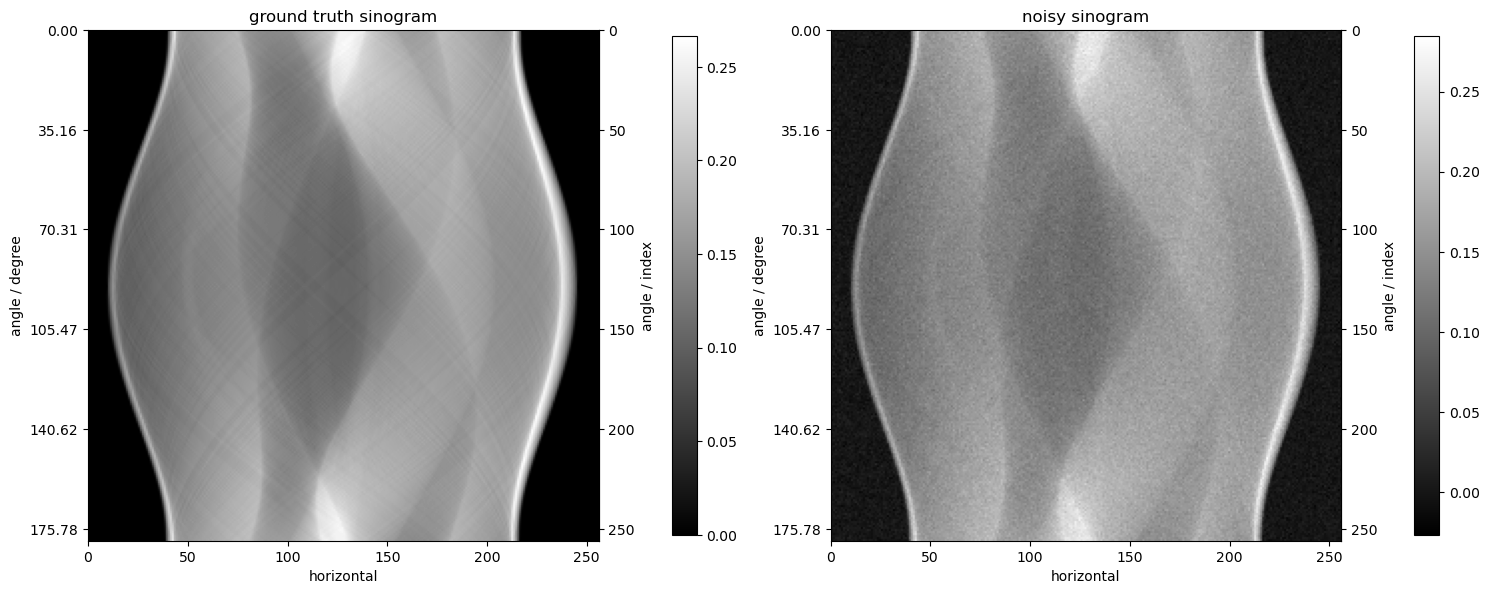

In [8]:
# visualise results
show2D([sino, sino_noisy], ['ground truth sinogram', 'noisy sinogram'], \
       cmap=cmap, num_cols=2, size=(15,10), origin='upper-left')

In [9]:
# reconstruct noisy data
# configure FBP
fbp = FBP(ig, ag, device)
# run on the AcquisitionData
recon_fbp_noisy = fbp(sino_noisy)

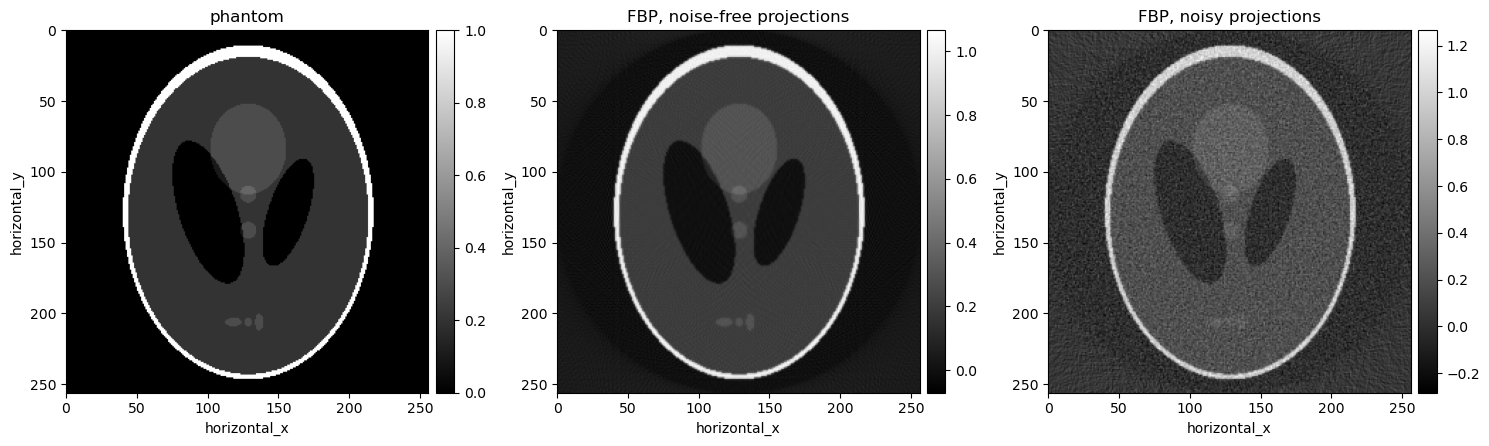

In [10]:
# visualise results
show2D([phantom, recon_fbp, recon_fbp_noisy], ['phantom', 'FBP, noise-free projections', 'FBP, noisy projections'], \
       cmap=cmap, num_cols=3, size=(15,10), origin='upper-left')

In [11]:
x0 = ig.allocate()
constraint = IndicatorBox(lower=0)

sirt = SIRT(initial=x0, operator=A, data=sino_noisy, constraint=constraint, max_iteration=100)
sirt.update_objective_interval = 10
sirt.run(100)

recon_sirt_noisy = sirt.solution

  0%|          | 0/100 [00:00<?, ?it/s]

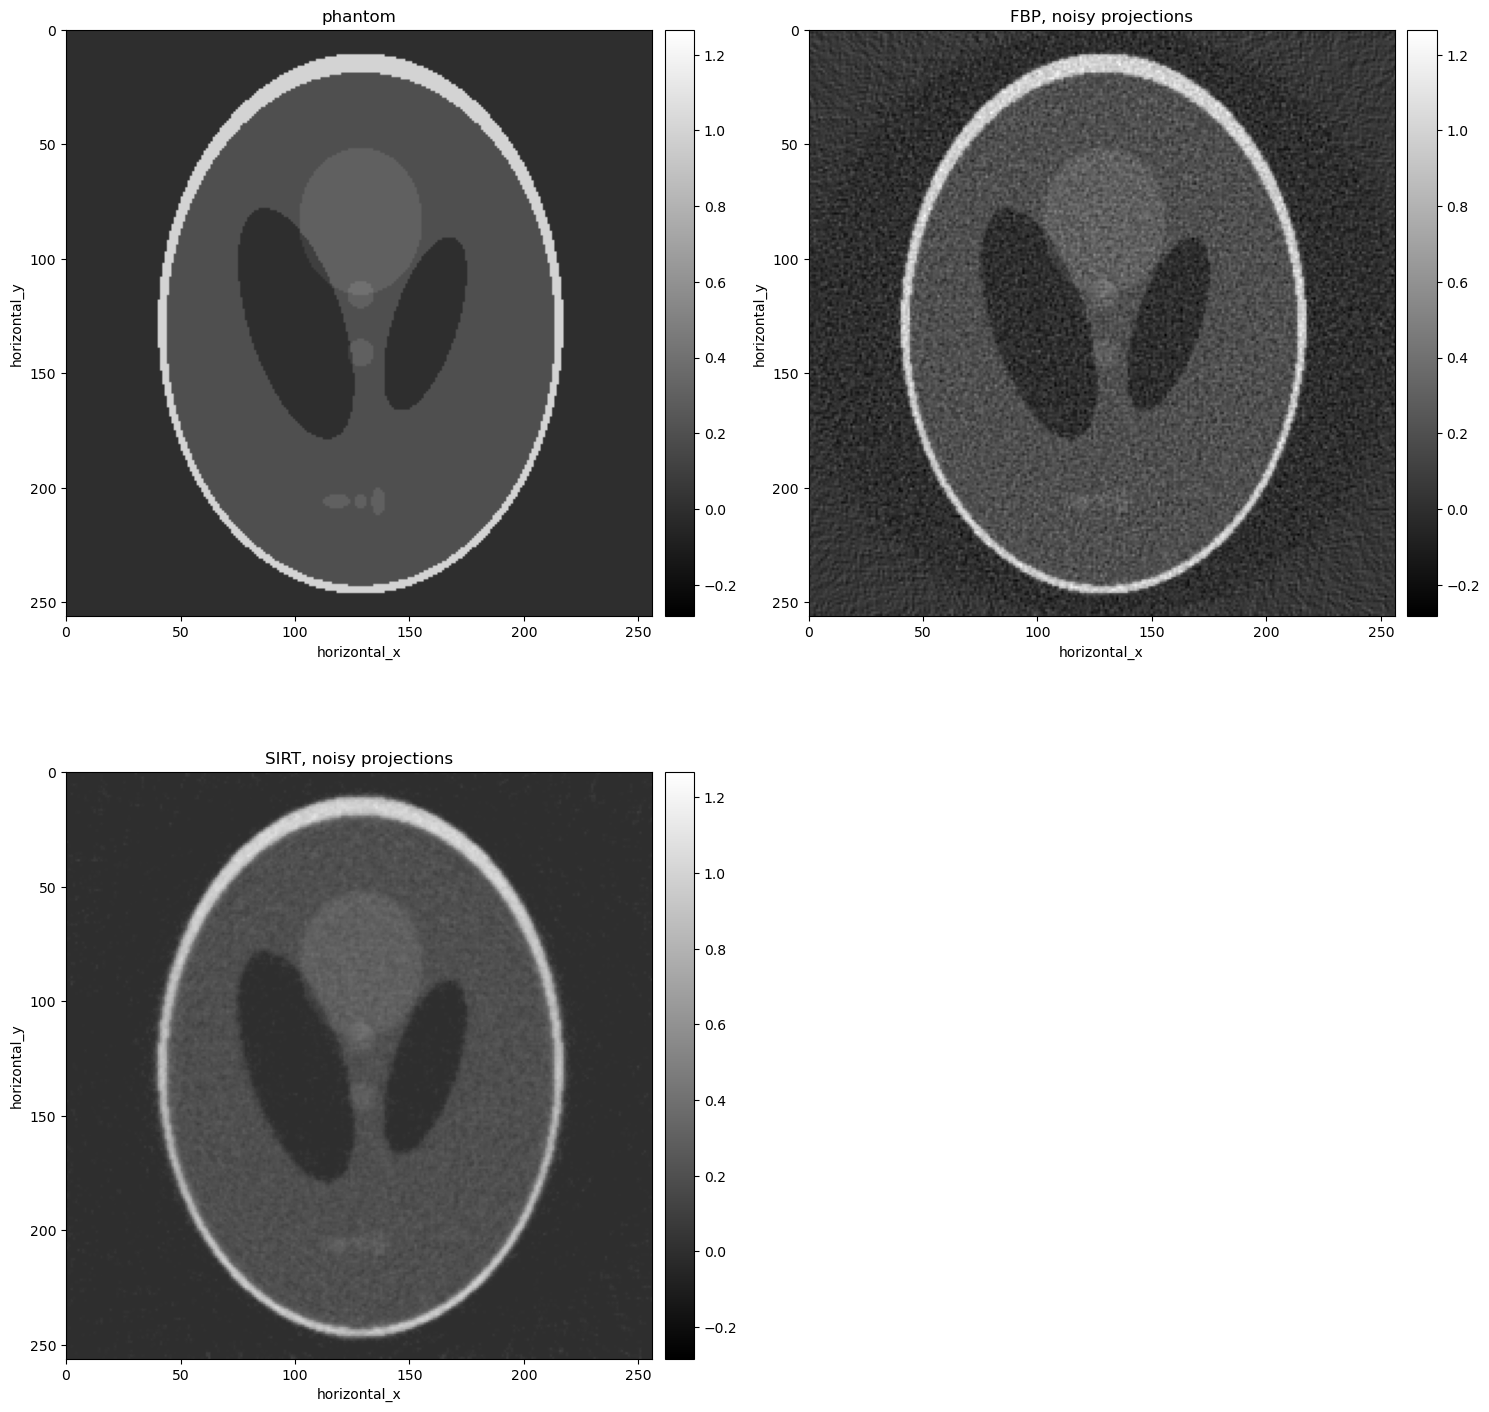

In [13]:
show2D([phantom, recon_fbp_noisy, recon_sirt_noisy], \
       ['phantom', 'FBP, noisy projections',  'SIRT, noisy projections'], \
       cmap=cmap, num_cols=2, size=(15,15), origin='upper-left', fix_range=True)

In [22]:
from cil.optimisation.operators import IdentityOperator
x0 = ig.allocate(0)
y0 = ig.allocate(0)

sirt = SIRT( operator=IdentityOperator(ig), data=y0)

sirt.run(100)

recon_sirt_noisy = sirt.solution

TypeError: SIRT.__init__() missing 1 required positional argument: 'initial'

In [23]:
from cil.optimisation.operators import IdentityOperator
x0 = ig.allocate(0)
y0 = ig.allocate(0)

sirt = CGLS( operator=IdentityOperator(ig), data=y0)

sirt.run(100)


IndexError: list index out of range